In [1]:
import graph_tool.all as gt
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
class Communities:
    """
    Class for dividing networks into communities
    """
    def __init__(self, graph, k, model='sbm'):
        """
        Initialize network with k communities according to a particular random graph model

        Args:
            graph (graph_tool.Graph): graph_tool graph object. Network to be partitioned into communities
            k (int): Number of communities to partition network into 
            model (str, optional): Random graph model according to which the network will be partitioned. Defaults to 'sbm'.
        """        
        self.graph = graph  # takes a graph_tool graph object
        self.num_groups = k  # number of groups to assign nodes to
        if model in ['sbm', 'dcsbm']:
            self.model = model
        else:
            raise ValueError('Invalid model. Choose from \'sbm\' or \'dcsbm\'')
        self.init_random_partition()  # randomly partition the network in to k groups
        self.curr_groups = self.partition()  # current group assignments

    def init_random_partition(self):
        """
        Randomly assigns groups to each node
        """               
        partitions = self.graph.new_vertex_property('int')
        self.graph.vertex_properties['group'] = partitions

        for u in self.graph.iter_vertices():
            partitions[u] = np.random.randint(self.num_groups)

    def partition(self):
        """
        Generates group assignment matrix

        Returns:
            groups (numpy.ndarray): group assignment matrix of shape number of nodes by number of groups
        """        
        groups = np.zeros(shape=(self.graph.num_vertices(),
                          self.num_groups), dtype=np.int32)

        labels = self.graph.vp.group.a
        for j in range(groups.shape[1]):
            for i in range(groups.shape[0]):
                groups[i, j] = 1 if j == labels[i] else 0

        return groups

    def sbm_likelihood(self):
        """
        Calculates the likelihood of the community structure according to the Stochastic Block Model

        Returns:
            float: Likelihood according to Stochastic Block Model
        """        
        n_nodes = self.graph.num_vertices()

        nodes_in_grp = self.curr_groups.sum(axis=0)
        two_m = 2*self.graph.num_edges()

        edge_adj = self.curr_groups.T@(gt.adjacency(
            self.graph).todense())@self.curr_groups

        L = 0
        for r in range(edge_adj.shape[0]):
            for s in range(edge_adj.shape[1]):
                if(edge_adj[r, s] == 0):
                    L += 0
                else:
                    log_exp = np.log(edge_adj[r, s])-np.log(nodes_in_grp[r]*nodes_in_grp[s])
                    L += (edge_adj[r, s]*log_exp)

        return L

    def dcsbm_likelihood(self):
        """
        Calculates the likelihood of the community structure according to the Degree Corrected Stochastic Block Model

        Returns:
            float: Likelihood according to the Degree Corrected Stochastic Block Model
        """    
        deg_in_group = (self.curr_groups.T @
                        gt.adjacency(self.graph).todense()).sum(axis=1)

        edge_adj = self.curr_groups.T@(gt.adjacency(
            self.graph).todense())@self.curr_groups
        two_m = 2*self.graph.num_edges()

        L = 0
        for r in range(edge_adj.shape[0]):
            for s in range(edge_adj.shape[1]):
                if(edge_adj[r, s] == 0):
                    L += 0
                else:
                    log_exp = np.log(edge_adj[r, s]) - np.log(deg_in_group[r, 0]*deg_in_group[s, 0])
                    L += (edge_adj[r, s]*log_exp)
        return L

    def get_communities(self):
        """
        Performs Kernighan-Lin (https://ieeexplore-ieee-org.proxy.lib.umich.edu/document/6771089) like moves to find optimal 
        community structure of network based on discussion by Karrer and Newman (https://arxiv.org/abs/1008.3926)

        Returns:
            list: best probability of each iteration of the algorithm
        """
        
        two_m = 2*self.graph.num_edges()
        n_nodes = self.graph.num_vertices()
        nodes = [i for i in range(n_nodes)]
        max_num_trials = 100

        if (self.model == 'sbm'):
            log_prob = self.sbm_likelihood
        else:
            log_prob = self.dcsbm_likelihood
            
        init_likelihood = log_prob()
        best_probs = [init_likelihood]

        for t in range(max_num_trials):
            unvisited = nodes.copy()
            t_best_config = np.zeros(shape=(n_nodes, n_nodes))
            max_probs = np.zeros(n_nodes)
            state = 0
            while(unvisited):
                probs = []
                for i in unvisited:
                    group_r = self.graph.vp.group[i]
                    curr_part = np.copy(self.curr_groups)
                    for group_s in range(self.num_groups):
                        if group_s != group_r:
                            self.graph.vp.group[i] = group_s
                            self.curr_groups = self.partition()
                            probs.append((log_prob(), i, group_s))

                            self.graph.vp.group[i] = group_r
                            self.curr_groups = np.copy(curr_part)
                    
                max_prob = max(probs)
                max_probs[state] = max_prob[0]
                self.graph.vp.group[max_prob[1]] = max_prob[2]
                t_best_config[state] = self.graph.vp.group.a.copy()
                unvisited.remove(max_prob[1])
                state += 1
            if ((max_probs.max() - max(best_probs)) <= 0):
                return best_probs
                
            self.graph.vp.group.a = t_best_config[max_probs.argmax()].copy()
            best_probs.append(max_probs.max())

        return best_probs

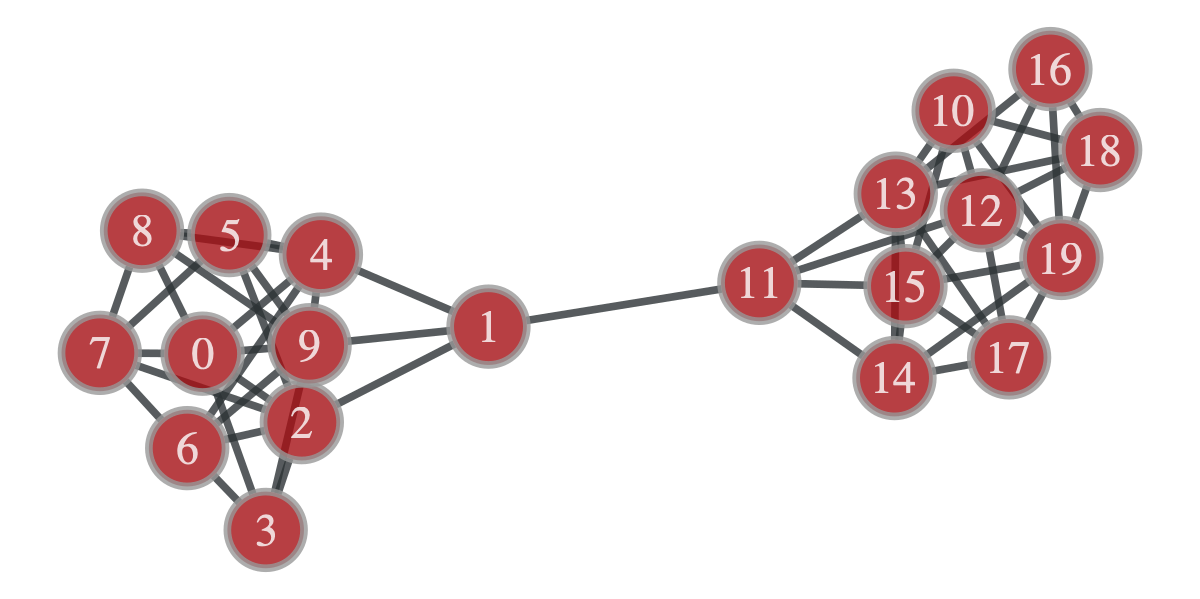

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fbf29356c10, at 0x7fbf2d1774f0>

In [3]:
test_graph = gt.load_graph('test_block_graph.graphml')
gt.graph_draw(test_graph, vertex_text=test_graph.vertex_index)

Text(0, 0.5, 'log likelihood')

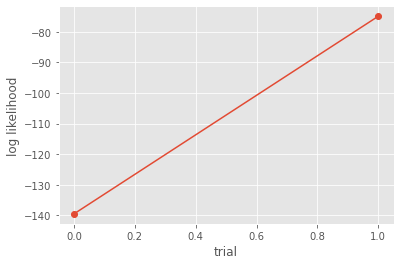

In [4]:
test_sbm = Communities(test_graph, 2, 'sbm')
sbm_probs = test_sbm.get_communities()
plt.plot(sbm_probs, marker='o')
plt.xlabel('trial')
plt.ylabel('log likelihood')

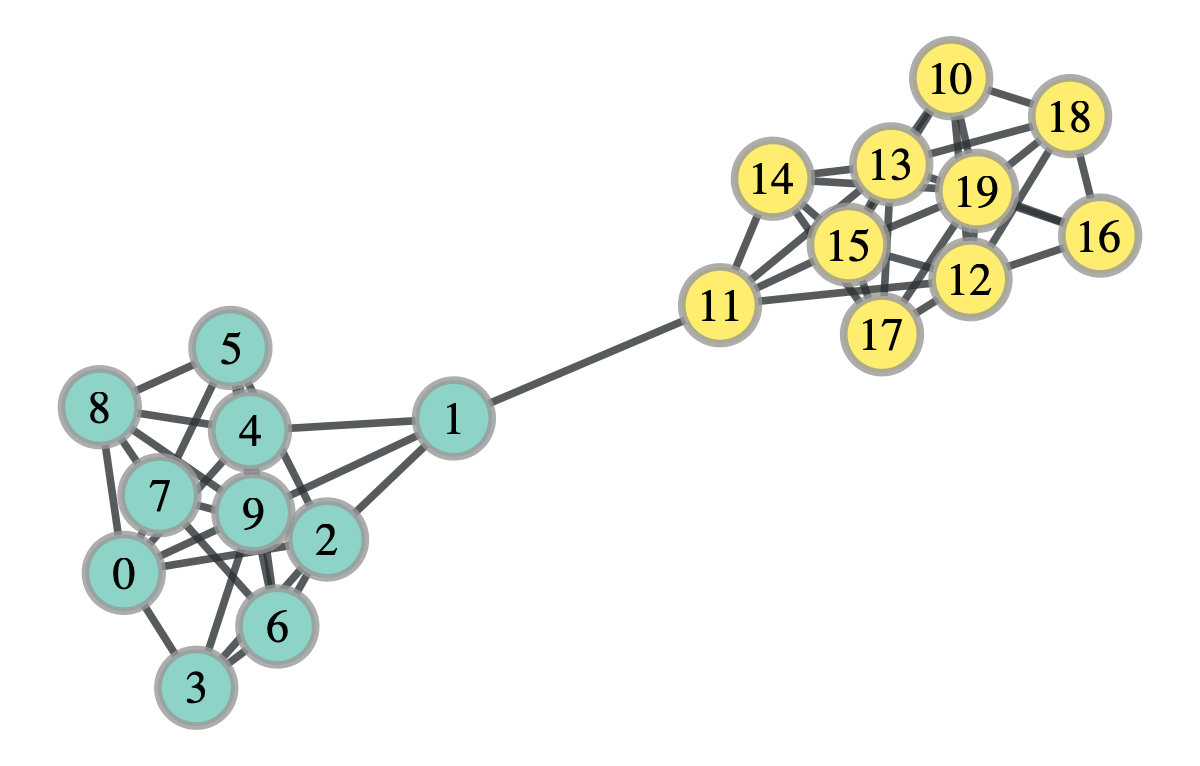

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fbf29356c10, at 0x7fbf2ebb23a0>

In [5]:
gt.graph_draw(test_sbm.graph, vertex_fill_color=test_sbm.graph.vp.group, vertex_text=test_sbm.graph.vertex_index)

Text(0, 0.5, 'log likelihood')

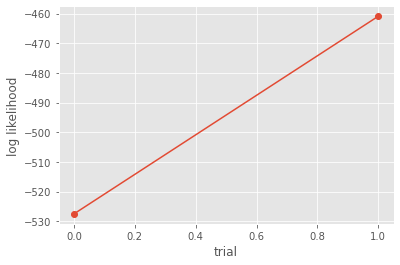

In [6]:
test_dcsbm = Communities(test_graph, 2, 'dcsbm')
dcsbm_probs = test_dcsbm.get_communities()
plt.plot(dcsbm_probs, marker='o')
plt.xlabel('trial')
plt.ylabel('log likelihood')

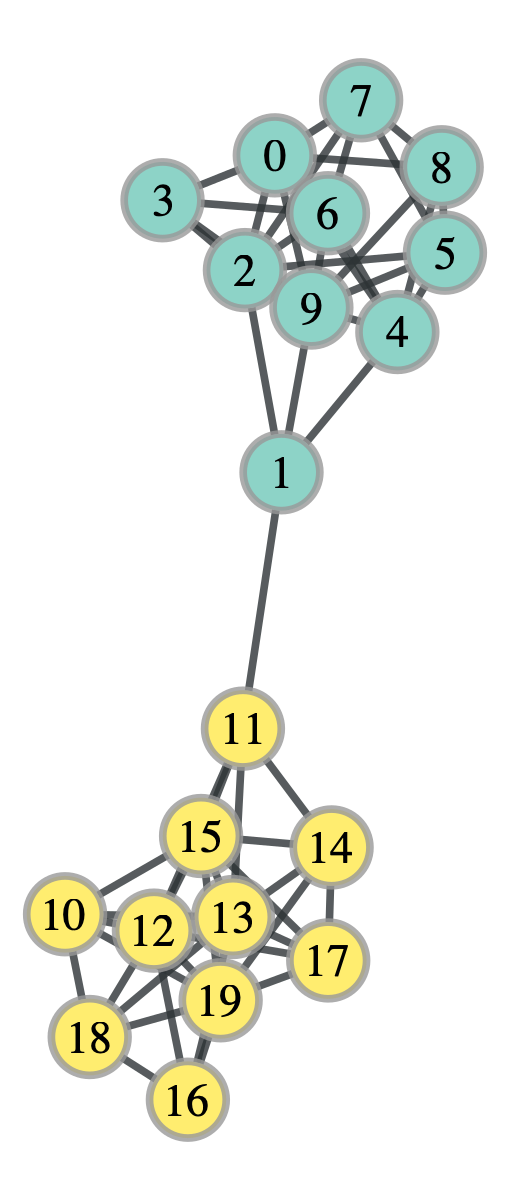

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fbf29356c10, at 0x7fbf2dc719a0>

In [7]:
gt.graph_draw(test_sbm.graph, vertex_fill_color=test_sbm.graph.vp.group, vertex_text=test_sbm.graph.vertex_index)

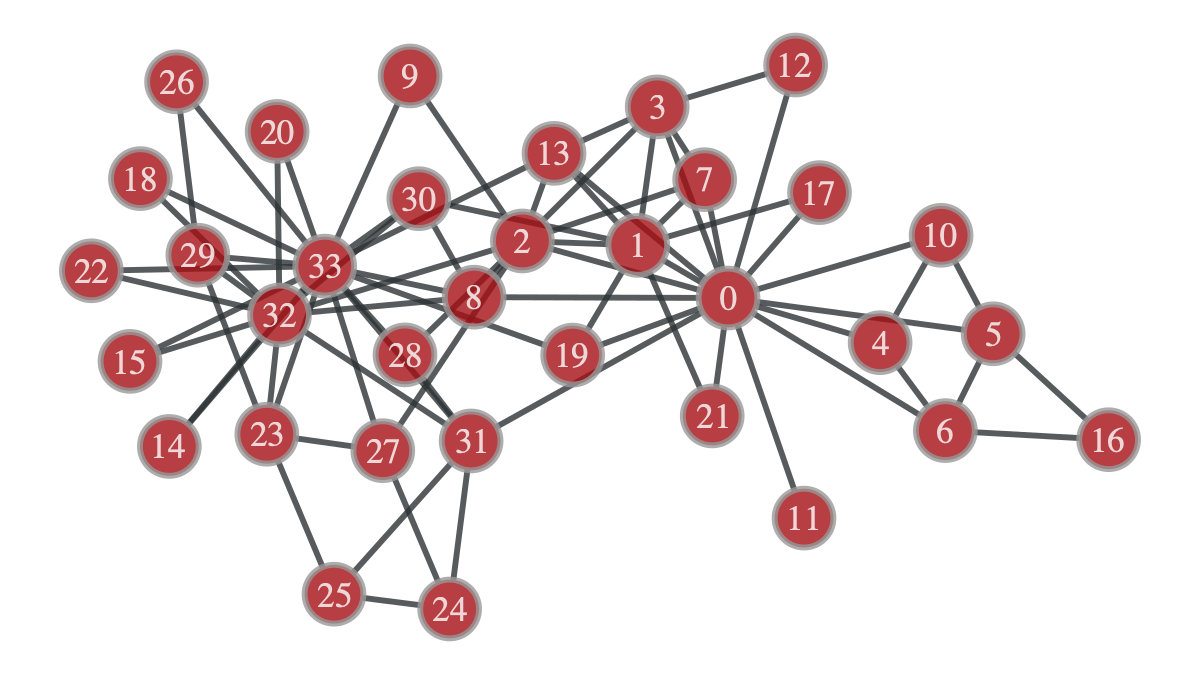

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fbf2dc7a400, at 0x7fbf293563a0>

In [8]:
k_club_graph = gt.collection.data['karate']
gt.graph_draw(k_club_graph, vertex_text=k_club_graph.vertex_index)

Text(0, 0.5, 'log likelihood')

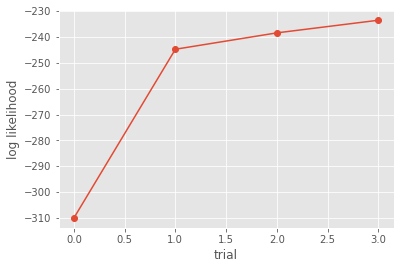

In [9]:
k_club = Communities(k_club_graph, 2, model='sbm')
k_club_probs = k_club.get_communities()
plt.plot(k_club_probs, marker='o')
plt.xlabel('trial')
plt.ylabel('log likelihood')

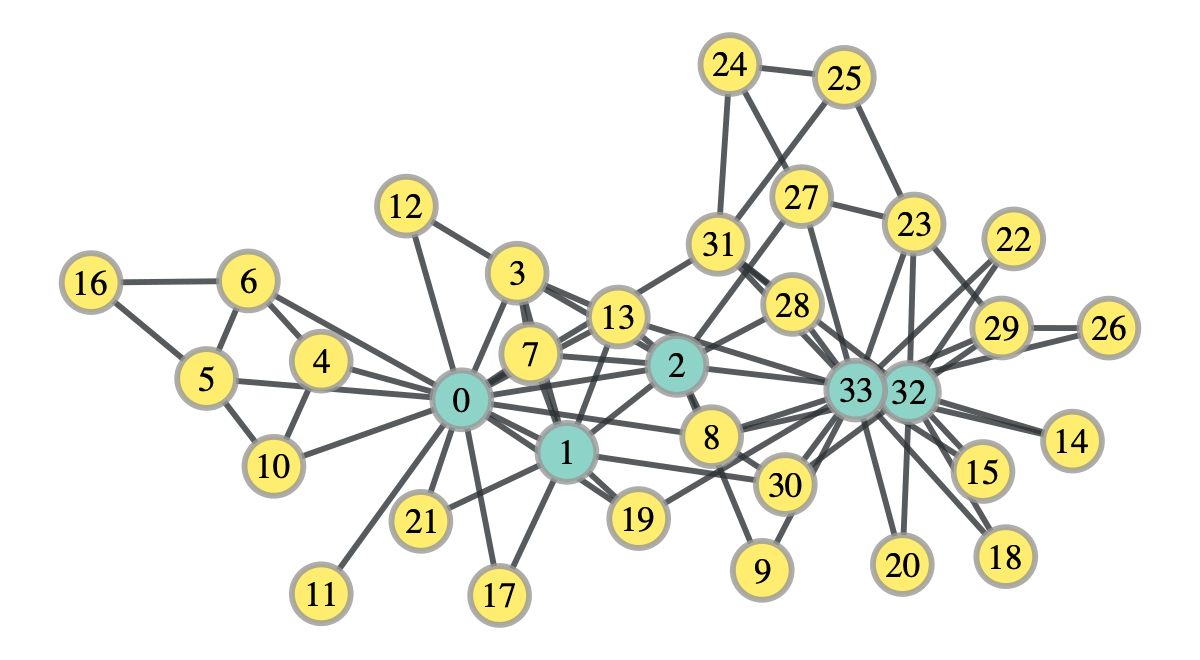

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fbf2dc7a400, at 0x7fbf300095b0>

In [10]:
gt.graph_draw(k_club.graph, vertex_fill_color=k_club.graph.vp.group, vertex_text=k_club.graph.vertex_index)

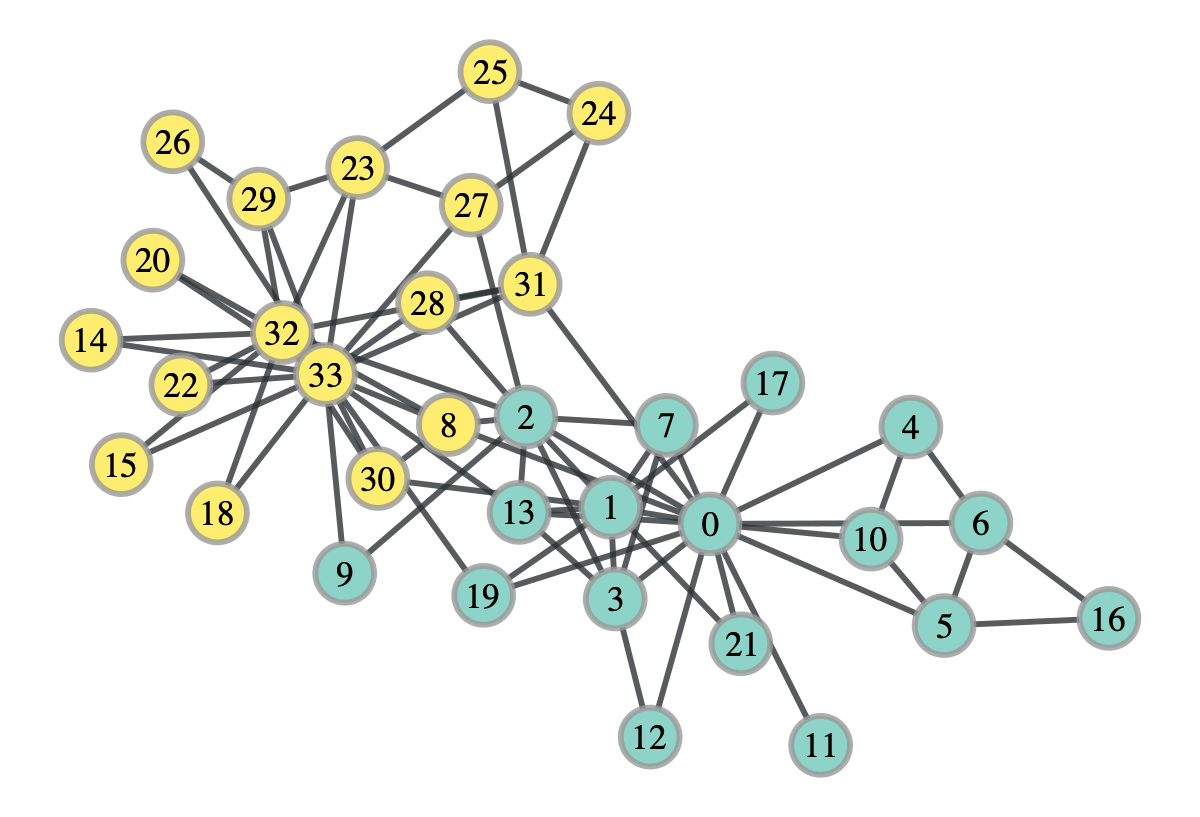

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fbf2dc7a400, at 0x7fbf2febcdc0>

In [11]:
gt.graph_draw(k_club.graph, vertex_fill_color=k_club.graph.vp.group, vertex_text=k_club.graph.vertex_index)

Text(0, 0.5, 'log likelihood')

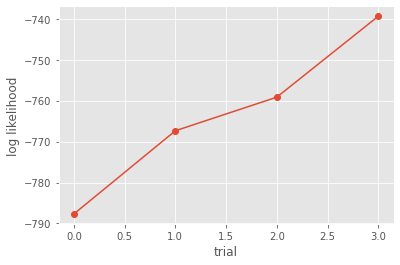

In [12]:
k_club_dc = Communities(k_club_graph, 2, model='dcsbm')
k_club_dc_probs = k_club_dc.get_communities()
plt.plot(k_club_dc_probs, marker='o')
plt.xlabel('trial')
plt.ylabel('log likelihood')

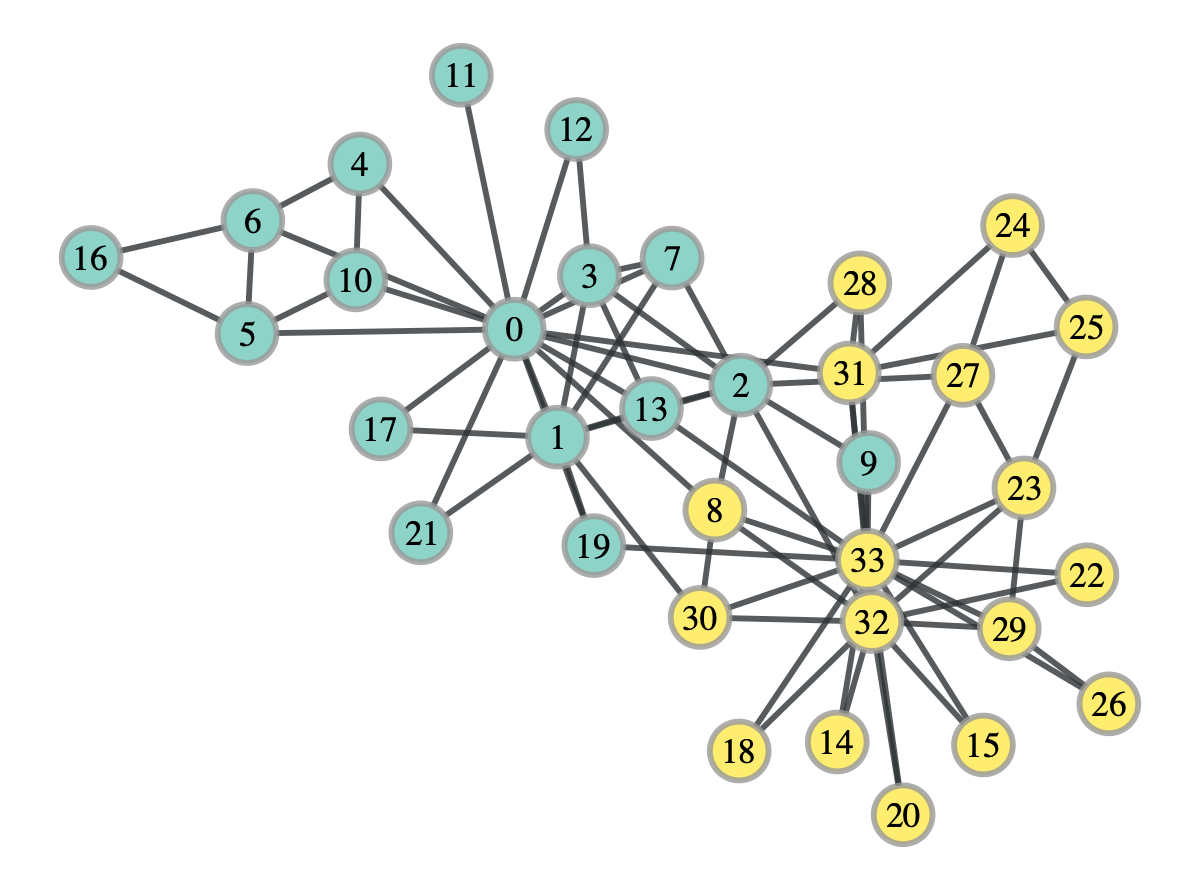

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fbf2dc7a400, at 0x7fbf300c3430>

In [13]:
gt.graph_draw(k_club_dc.graph, vertex_fill_color=k_club_dc.graph.vp.group, vertex_text=k_club_dc.graph.vertex_index)